In [4]:
# Example usage:
from invasion import (
    compute_nontrivial_slice,
    simulate_segment,
    compute_deltaW_curve,
    compare_severities,
    test_plot,
    compare_scalers,
    run_cycles,
    run_cycles_ext,
    simulate_segment2,
    run_invasion,
    pairwise_invasion_plot,
    piplot,
    local_invasibility_heatmap
)

W_birth = 0.4
W_death = 0.1
Y_birth = 0.9
Y_death = 0.15

X_in = 0.1
X_out = 0.1
Z_in = 0.5
Z_out = 0.25

Time = 600.0
dt = 0.1

use_X = True
use_Z = False

num_points = 100
severity = 0.5
cycles = 10000
extinction_rate = 50
U_out = 0.05
U_in = U_out
X_out = 0.06
X_in = X_out

W,Y = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
W0 = W/2
X0 = W0 / (X_out / X_in)
V0 = W - W0
U0 = V0 / (U_out / U_in)
Y0 = Y
Z0 = Y0/ (Z_out /Z_in)
dt = 0.1

Scanning U_in: 100%|██████████| 100/100 [10:04:40<00:00, 362.81s/it]  


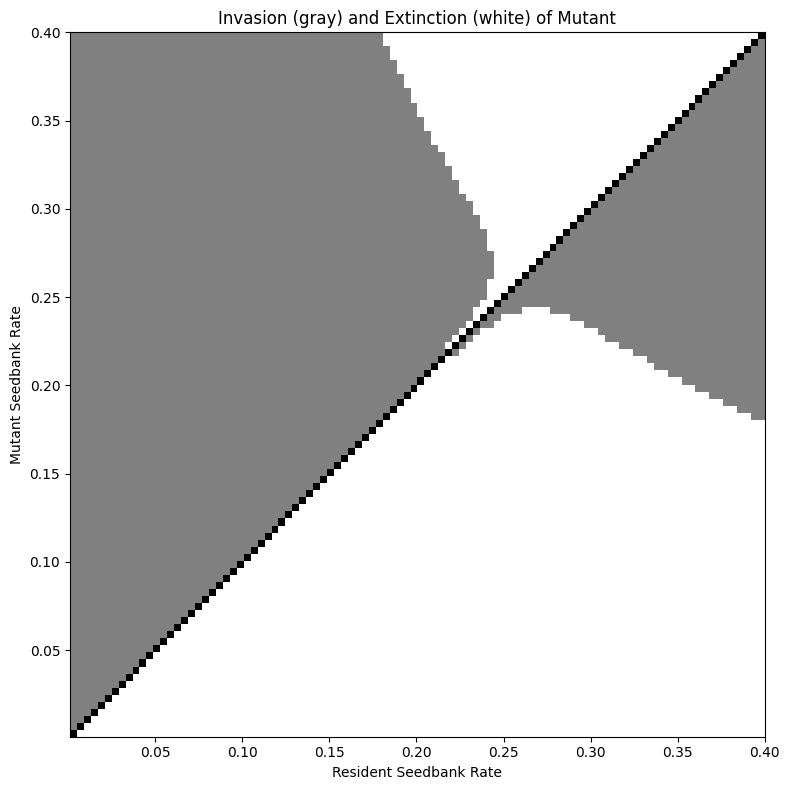

In [5]:
x = piplot(
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=100,
    U_min=0.001, U_max=0.4,
    X_min=0.001, X_max=0.4)

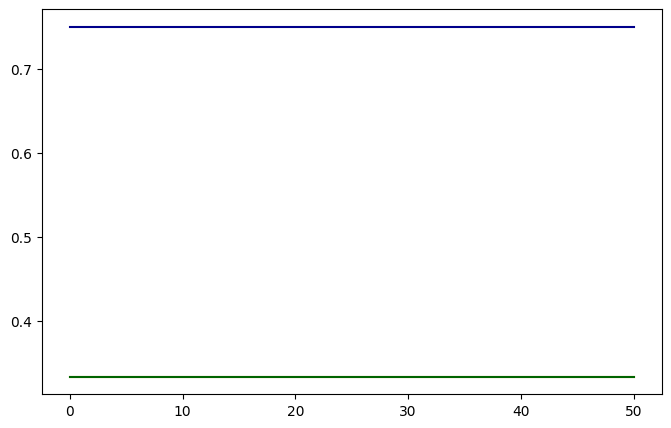

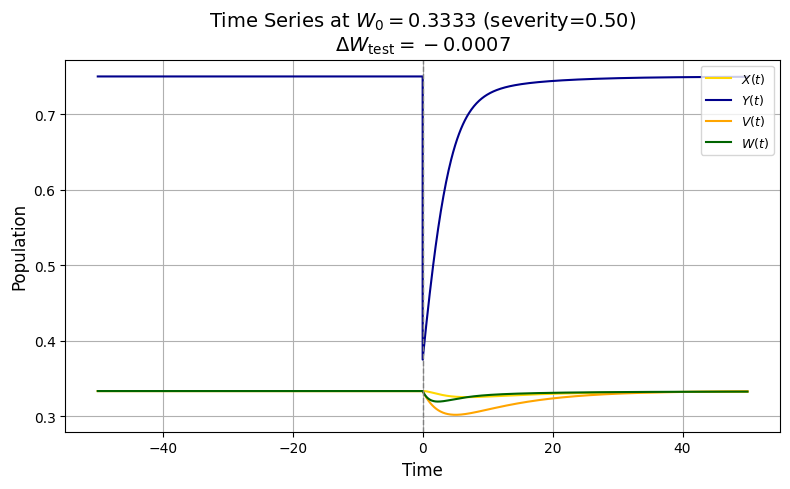

In [20]:
x = test_plot2(U0=U0, V0=V0, W0=W0, X0=X0, Y0=Y0, Z0=Z0,
           W_birth=W_birth, Y_birth=Y_birth,
           W_death=W_death, Y_death=Y_death,
           X_in=X_in, X_out=X_out,
           Z_in=Z_in, Z_out=Z_out,
           U_in=U_in, U_out=U_out,
           Time=50, dt=dt,
    use_X=use_X, use_Z=use_Z,
    severity=severity,
    perturb_W=False, perturb_Y=True,
    perturb_time=50,
    tol=1e-6)

In [ ]:
from typing import Dict, Tuple, Any
from collections import defaultdict

def nest_dict(
    orig: Dict[Tuple[Any, Any], Any]
) -> Dict[Tuple[Any, Any], Dict[Tuple[Any, Any], Any]]:
    """
    Transform a dict whose keys are 2-tuples of 2-tuples into a nested dict.
      { ((a,b),(c,d)): v, … }
    → { (a,b): { (c,d): v, … }, … }
    """
    nested: Dict[Tuple[Any, Any], Dict[Tuple[Any, Any], Any]] = defaultdict(dict)
    for (outer, inner), value in orig.items():
        nested[outer][inner] = value
    return dict(nested)


def local_invasibility_heatmap(
    V0, W0, Y0, X0, Z0, U0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=5,
    U_in_min=0.01, U_in_max=0.99,
    U_out_min=0.01, U_out_max=0.99,
    folder='total_invasibility',
):
    """
    For each interior gridpoint (i,j) on [0,1]^2 in U_in, X_in:
      • Evaluate run_invasion at its 8 nearest neighbors
      • Compute mean of their np.sign(deltaW)
      • Plot that in grayscale (1=black…+1=white)
    """

    # 1) Prepare output directory
    os.makedirs(folder, exist_ok=True)

    # 2) Build the [0,1] grid
    U_in_vals = np.linspace(U_in_min, U_in_max, grid_size)
    U_out_vals = np.linspace(U_out_min, U_out_max, grid_size)

    # 3) Initialize the score matrix
    score = np.zeros((grid_size, grid_size))

    # 4) Offsets for the eight neighbors
    neighbor_offsets = [(-1,-1), (-1,0), (-1,1),
                        ( 0,-1),         ( 0,1),
                        ( 1,-1), ( 1,0), ( 1,1)]
    deltas = {}
    # 5) Loop over interior points
    for i in tqdm(range(1, grid_size-1), desc="Computing local invasibility"):
        for j in range(1, grid_size-1):
            invasions = 0
            for di, dj in neighbor_offsets:
                X_in = U_in_vals[i+di]
                X_out = U_out_vals[j+dj]

                if ((i+di,j+dj), (i,j)) in deltas.keys():
                    if deltas[((i+di,j+dj), (i,j))] == 0:
                        invasions += 1
                        deltas[((i,j), (i+di,j+dj))] = 1
                    else:
                         deltas[((i,j), (i+di,j+dj))] = 0
                else:
                    # Here we keep X_out = X_in and U_out = U_in for simplicity
                    deltaW = run_invasion(
                        V0, W0, Y0, X0, Z0, U0,
                        W_birth, Y_birth, W_death, Y_death,
                        X_in, Z_in,    # X_in
                        X_out, Z_out,   # X_out
                        U_in_vals[i], U_in_vals[j],      # U_in, U_out
                        extinction_rate, dt,
                        use_X, use_Z,
                        cycles, severity,
                        perturb_W=False, perturb_Y=True,
                        plot=False
                    )
                    if deltaW> 0:
                        invasions += 1
                        deltas[((i,j), (i+di,j+dj))] = 1
                    else:
                        deltas[((i,j), (i+di,j+dj))] = 0

                # store the mean sign ∈ [–1,+1]
            score[i, j] = invasions

    # 6) Plot the result as a grayscale PDF
    #    –1 → black; +1 → white
    mask = np.zeros_like(score, dtype=bool)
    mask[ 0, :] = True   # top row
    mask[-1, :] = True   # bottom row
    mask[:,  0] = True   # left column
    mask[:, -1] = True   # right column
    score_masked = np.ma.array(score, mask=mask)

    cmap = plt.get_cmap('tab10', 9)
    cmap.set_bad(color='white') 

    # 2. Create a norm that bins values 0–8 into 9 discrete intervals.
    bounds = np.arange(-0.5, 9.5, 1)     # edges at -0.5, 0.5, 1.5, …, 8.5
    norm   = BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=(9,8))
    im = plt.imshow(
        score_masked,
        origin='lower',
        extent=[U_in_min, U_in_max,U_out_min,U_out_max],
        aspect='equal',
        cmap=cmap,
        norm=norm
    )
    plt.xlabel('U_in')
    plt.ylabel('U_out')
    plt.title('Local invasibility (mean sign of ΔW among 8 neighbors)')
    cbar = plt.colorbar(im, ticks=np.arange(0, 9, 1), boundaries=bounds)
    cbar.set_label('Count of invading neighbors')
    plt.tight_layout()

    # save a new file without overwriting
    existing = sorted([p for p in os.listdir(folder) if p.startswith('local_inv') and p.endswith('.pdf')])
    idx = int(re.search(r'\d+', existing[-1]).group())+1 if existing else 0
    fname = os.path.join(folder, f'local_inv{idx}.pdf')
    plt.savefig(fname)
    plt.show()

    # 7) Return for further use
    return U_in_vals, U_out_vals, score, nest_dict(deltas)



In [ ]:
x = local_invasibility_heatmap(
    V0, W0, Y0, X0, Z0, U0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=4
)

In [ ]:
x[:3]

Saved run_invasion plot to run_invasion/run_invasion48.pdf


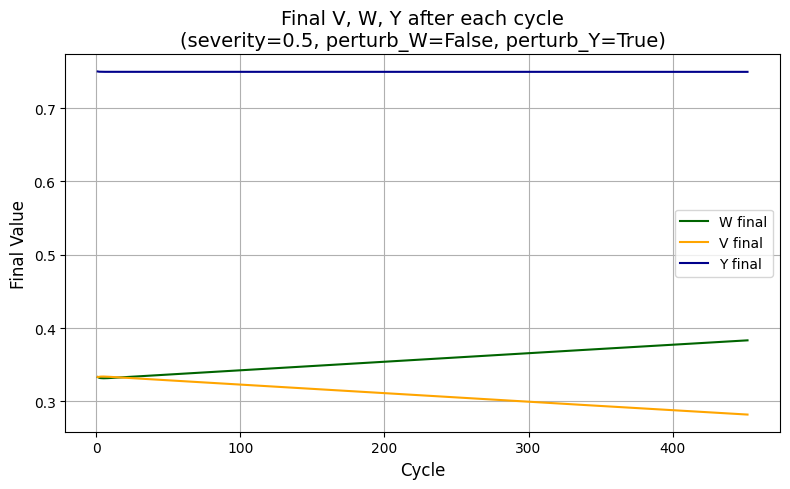

In [16]:
x = run_invasion(V0=V0, W0=W0, Y0=Y0, X0=X0, Z0=Z0, U0=U0,
               W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
               X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, U_in=U_in, U_out=U_out,
               extinction_rate=extinction_rate, dt=dt,
               use_X=use_X, use_Z=use_Z,
               cycles=cycles,
               severity=severity,
               perturb_W=False,
               perturb_Y=True )

In [6]:
x

0.0500032332924677